# **Introduction to Text Mining and Natural Language Processing**


<div style="text-align: center;">
  <img src="https://bse.eu/sites/default/files/bse_logo_small.png" alt="bse_logo_textminingcourse">
</div>


## **Homework 2: Mini Research Project**



## **Part 1.1: Getting the Data**
- [ Project Imports](#2.1)
- [ Dataset Overview: Mental Health Corpus](#2.2)

## **Part 1.2: Data Pre-processing**
- [Splitting the Main Corpus](#3.1)
- [Text Preprocessing Setup](#3.2)
  - [Visualization: Word Clouds (`df, text_column`)](#3.2.1)
  - [Lowercasing & Stopword Removal (`preprocess_lower`)](#3.2.2)
  - [Stemming (`preprocess_stem`)](#3.2.3)
  - [Lemmatization (`preprocess_lemma`)](#3.2.4)
  - [Tokenization (`tokenize`)](#3.2.5)
- [Applying Preprocessing Functions](#3.3)
- [Frequency Count](#3.4)
- [Results Visualization](#3.5)
- [Checkpoint 1: Pre-Process](#3.6)

## **Part 3: Analysis: TF-IDF, LDA**
- [4.1 Why TF-IDF?](#4.1)
- [4.2 Identifying Key Features with TF-IDF](#4.2)
- [4.3 Comparison of Top Words per Class](#4.3)






# Part 1: Getting The Data

## Project imports

In [29]:
# Text Processing Libraries
import re  # Regular expressions
import nltk  # Natural Language Toolkit
import spacy  # Advanced NLP processing


# Stemming and Lemmatization
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

# Tokenization and Stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Machine Learning & Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Dateframes and file reading
import pandas as pd
import os
from tqdm.notebook import tqdm
tqdm.pandas()
from collections import Counter

import seaborn as sns

# Download necessary NLTK resources (if not already downloaded)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


True

## 1.1 Dataset Overview: Mental Health Corpus

The **Mental Health Corpus** is a dataset containing texts related to *anxiety, depression*, and other mental health issues. It includes user comments labeled as either **poisonous** or **not**, making it useful for **sentiment analysis, toxic language detection**, and **mental health research**.

*(Mental Health Corpus, n.d.). Retrieved from Kaggle:*  
[🔗 Mental Health Corpus on Kaggle](https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus)

### Dataset Information
The data is stored in a file named `mental_health.csv` and consists of the following columns:

| Column Name | Description |
|-------------|------------|
| `text`  | User-generated comments |
| `label` | Binary classification: **1** means a comment is considered poisonous related to mental health issues, and **0** means it is not. |


In [30]:
csv_directory = os.path.join(os.getcwd(), "files", "general_results")
df = pd.read_csv("data/mental_health.csv")
df.head()


,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


We observe that our **DataFrame** contains **27,977 rows**, with each row corresponding to a **unique comment**.

🔍 **Observations:**
-  We confirm that there are **no null or missing values** in the dataset.
-  The distribution of labels is around **50%**, meaning we are dealing with a **balanced dataset**.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


In [32]:
# Count of Labels with the value 0  / Total count of Labels.
len(df[df['label']==0]) / len(df['label'])

0.5053794188083068

## 1.2 Data Pre-processing:

### **Splitting the Main Corpus**

We will divide the **Mental Health Corpus** (`mental_health.csv`) into two distinct **Sub-Corpus** based on the **binary classification (`label`)**:

- **`df_filtered_0`** → Contains only comments labeled as **`0`**, meaning they are **non-related** to mental health issues.
- **`df_filtered_1`** → Contains only comments labeled as **`1`**, meaning they are **toxic or distressing**.

This separation allows for a more targeted analysis of both **neutral** and **mental health-related** texts.


In [33]:
df_filtered_0 = df[df["label"] == 0]  # Extract all rows where label == 0 (Non-Toxic)
df_filtered_1 = df[df["label"] == 1]  # Extract all rows where label == 1 (Toxic)

df_filtered_0.head()
df_filtered_1.head()

,text,label
1,nothing look forward lifei dont many reasons k...,1
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
5,hey rredflag sure right place post this goes ...,1
7,deserve liveif died right noone would carei re...,1


### **Text Preprocessing Setup**

We define several preprocessing functions to **clean and transform text** for **Natural Language Processing (NLP)** tasks.

🔧 **Initialization of Key Variables:**
-  **`sp`** → Pre-trained **spaCy model** (`en_core_web_sm`) for **lemmatization**.
-  **`porter`** → **SnowballStemmer** (from `nltk`) for **stemming**.
-  **`lmtzr`** → **WordNetLemmatizer** (from `nltk`) for **lemmatization**.
-  **`custom_stopwords`** → Custom dictionary with a list of **stop-words** selected based on testing. 

In [ ]:
# Load spaCy model
sp = spacy.load("en_core_web_sm")

# Load previous preprocessing functions
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

STOP_WORDS = set(stopwords.words('english'))

# Custom stop words related to mental health
custom_stopwords = {'like', 'im','ive', 'going', 'got','go', 's', 'year', 'way', 'day', 'br', 'see', 'even', 'one', 'still'
, 'really', 'think', 'make', 'know', 'thing'}
STOP_WORDS.update(custom_stopwords)



#### 🔹 **Visualization: Word Clouds (`df, text_column`)**

In [51]:
# Define a function to generate word clouds for each class
def generate_wordclouds(df, text_column, stopwords=None):
    label_corpus = {}
    
    
    # Iterate through each unique class in the dataset
    for label in df['label'].unique():
        # Filter descriptions by label
        text_corpus = " ".join(df[df['label'] == label][text_column].dropna())
        
        # Store the processed text in the dictionary
        label_corpus[label] = text_corpus
    
    # Generate and display word clouds side by side
    num_label = len(label_corpus)
    fig, axes = plt.subplots(1, num_label, figsize=(10 * num_label, 5))
    
    if num_label == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one class
    
    for ax, (label, text) in zip(axes, label_corpus.items()):
        if text.strip():  # Ensure the text is not empty
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white', 
                colormap='viridis', 
                max_words=100,
                stopwords=custom_stopwords
            ).generate(text)
            
            # Display the word cloud
            ax.imshow(wordcloud, interpolation="bilinear")
            ax.axis("off")  # Remove axes
            ax.set_title(f"Word Cloud for {label}")
    
    plt.show()


#### 🔹 **Lowercasing & Stopword Removal (`preprocess_lower`)**
- Converts text to **lowercase**.
- **Removes punctuation** and tokenizes words.
- **Filters out stopwords** (default + custom mental health-related stopwords).


In [36]:

def preprocess_lower(text):
    
    # Lowercase the text
    text_lower = text.lower()

    # Remove punctuation (everything except word characters and whitespace)
    text_no_punct = re.sub(r'[^\w\s]', '', text_lower)

    # Tokenize the cleaned text.
    tokens = word_tokenize(text_no_punct)

    # Filter out stopwords.
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]

    return " ".join(filtered_tokens)



#### 🔹 **Stemming (`preprocess_stem`)**
- Applies **stemming** using the **Porter Stemmer**.
- Uses preprocessed text from `preprocess_lower` and reduces words to their root forms.


In [37]:


def preprocess_stem(text):

    # Get the cleaned lowercased and stopwords-removed tokens.
    joined_tokens = preprocess_lower(text)
    
    tokens=word_tokenize(joined_tokens)

    # Initialize the Porter Stemmer.
    ps = PorterStemmer()

    # Stem each token.
    stemmed_tokens = [ps.stem(token) for token in tokens]

    return " ".join(stemmed_tokens)



#### 🔹 **Lemmatization (`preprocess_lemma`)**
- Uses **spaCy** to extract the **lemma** of each token.
- Removes **stopwords and punctuation** for cleaner text.
- **No Lowercasing applied.**


In [38]:
def preprocess_lemma(text):

    # Process text using spaCy
    doc = sp(text)

    # Extract the lemma of each token, filtering out tokens flagged as punctuation or stopwords.
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.lemma_.strip() != '']

    return " ".join(lemmatized_tokens)



#### 🔹 **Tokenization (`tokenize`)**
- A flexible function to apply **lowercasing (mode 0), stemming (mode 1), or lemmatization (mode 2)**.
- Raises an error for invalid mode selections.

In [39]:
def tokenize(text, mode=0):

    if mode == 0:
        return preprocess_lower(text)
    elif mode == 1:
        return preprocess_stem(text)
    elif mode == 2:
        return preprocess_lemma(text)
    else:
        raise ValueError("Invalid mode. Please use 0 for lowercasing, 1 for stemming, or 2 for lemmatizing.")

### **Applying Preprocessing Functions**

Now, we apply our **text preprocessing functions** to the main corpus and create **new columns** in our DataFrame for comparison purposes.

In [40]:
df['text_no_stopwords']= df['text'].progress_apply(lambda x: preprocess_lower(x) if pd.notna(x) else "")
df['text_stem']= df['text_no_stopwords'].progress_apply(lambda x: preprocess_stem(x) if pd.notna(x) else "")
df['text_lemma']= df['text_no_stopwords'].progress_apply(lambda x: preprocess_lemma(x) if pd.notna(x) else "")
df

  0%|          | 0/27977 [00:00<?, ?it/s]

  0%|          | 0/27977 [00:00<?, ?it/s]

  0%|          | 0/27977 [00:00<?, ?it/s]

,text,label,text_no_stopwords,text_stem,text_lemma
0,dear american teens question dutch person hear...,0,dear american teens question dutch person hear...,dear american teen question dutch person heard...,dear american teen question dutch person hear ...
1,nothing look forward lifei dont many reasons k...,1,nothing look forward lifei dont many reasons k...,noth look forward lifei dont mani reason keep ...,look forward lifei not reason feel keep make w...
2,music recommendations im looking expand playli...,0,music recommendations looking expand playlist ...,music recommend look expand playlist usual gen...,music recommendation look expand playlist usua...
3,im done trying feel betterthe reason im still ...,1,done trying feel betterthe reason alive know m...,done tri feel betterth reason aliv know mum de...,try feel betterthe reason alive know mum devas...
4,worried year old girl subject domestic physic...,1,worried old girl subject domestic physicalment...,worri old girl subject domest physicalment hou...,worried old girl subject domestic physicalment...
...,...,...,...,...,...
27972,posting everyday people stop caring religion ...,0,posting everyday people stop caring religion m...,post everyday peopl stop care religion matter ...,post everyday people stop care religion matter...
27973,okay definetly need hear guys opinion ive pret...,0,okay definetly need hear guys opinion pretty m...,okay definetli need hear guy opinion pretti mu...,okay definetly need hear guy opinion pretty lo...
27974,cant get dog think ill kill myselfthe last thi...,1,cant get dog ill kill myselfthe last thing hol...,cant get dog ill kill myselfth last thing hold...,not dog ill kill myselfthe thing hold yup appl...
27975,whats point princess bridei really think like ...,1,whats point princess bridei wesley said pb lif...,what point princess bridei wesley said pb life...,s point princess bridei wesley say pb life pai...


### 🔄 **Iterative Stopword Refinement Process**

We **visualize word frequency** after **removing standard stopwords**. This allows us to identify **high-frequency words** that are **topic-general** but **not relevant** to our analysis.


1. **Visualize word counts** to detect common, non-informative words.
2. **Identify problematic words** that still appear frequently but add little value.
3. **Add these words to `custom_stopwords`** to refine the dataset.
4. **Repeat the process** until we filter out unnecessary words.


This step ensures that our final **lemmatized dataset** captures the most **meaningful words** for analysis. 


In [41]:
# Flatten all words from the 'text_no_stopwords' column into a single list
all_words = " ".join(df['text_no_stopwords'].dropna()).split()

# Count occurrences of each word
word_frequencies = Counter(all_words)


# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

word_freq_df.head(30)


,Word,Frequency
31,want,17299
90,know,15475
27,feel,14508
99,life,14386
8,get,13094
49,people,11249
306,would,11001
199,time,10829
140,cant,10446
408,never,8031


###  **Results Visualization**

####  ☁ Word Cloud Interpretation:
-   **Word Cloud for `label = 0`** → Displays **neutral or non-negative** mental health-related words.
-  **Word Cloud for `label = 1`** → Represents words related to **mental distress, anxiety, and depression**.

These visualizations help us **understand the dominant themes** in each category and analyze the distribution of words in the dataset.


*World Cloud Before Pre-Processing*

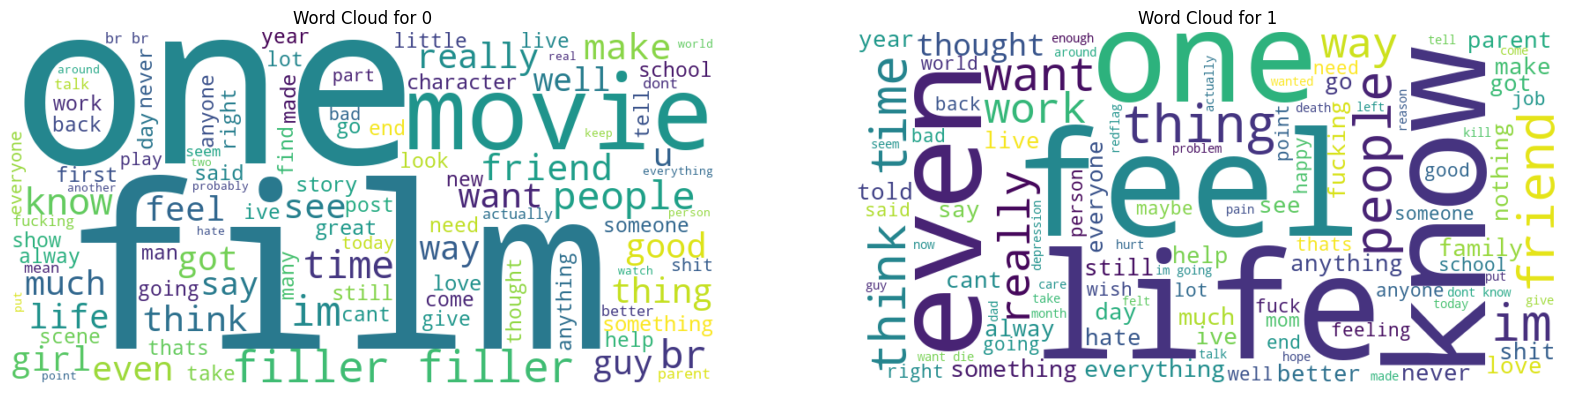

In [49]:
generate_wordclouds(df, 'text')

*World Cloud after Pre-processing*

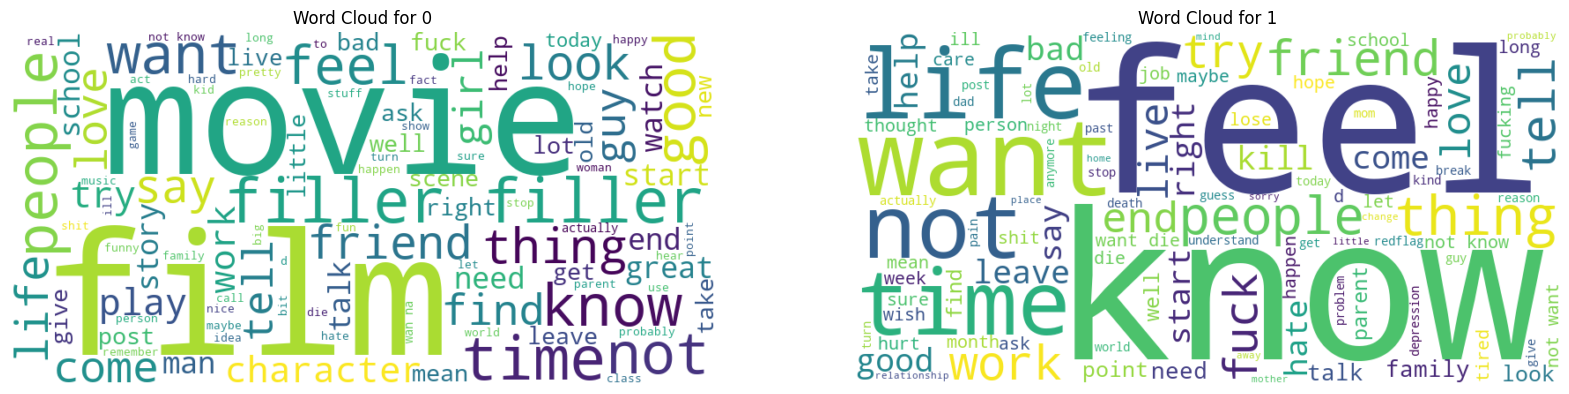

In [52]:
generate_wordclouds(df, 'text_lemma', stopwords=custom_stopwords)

### Checkpoint 1: Pre-Process

The preprocessed text is saved in a CSV file for subsequent steps.  This is necessary because the preprocessing itself requires approximately 10 minutes.

In [44]:
df.to_csv("data/preprocessing/mental_health_preprocessed.csv")

# Part 2: Analysis  using TF-IDF

*Getting the first 30 features by class*

In [45]:
df = pd.read_csv("data/preprocessing/mental_health_preprocessed.csv")
df.head()

,Unnamed: 0,text,label,text_no_stopwords,text_stem,text_lemma
0,0,dear american teens question dutch person hear...,0,dear american teens question dutch person hear...,dear american teen question dutch person heard...,dear american teen question dutch person hear ...
1,1,nothing look forward lifei dont many reasons k...,1,nothing look forward lifei dont many reasons k...,noth look forward lifei dont mani reason keep ...,look forward lifei not reason feel keep make w...
2,2,music recommendations im looking expand playli...,0,music recommendations looking expand playlist ...,music recommend look expand playlist usual gen...,music recommendation look expand playlist usua...
3,3,im done trying feel betterthe reason im still ...,1,done trying feel betterthe reason alive know m...,done tri feel betterth reason aliv know mum de...,try feel betterthe reason alive know mum devas...
4,4,worried year old girl subject domestic physic...,1,worried old girl subject domestic physicalment...,worri old girl subject domest physicalment hou...,worried old girl subject domestic physicalment...


In [46]:
# Separate texts based on label
texts_0 = df[df["label"] == 0]["text_lemma"].dropna().tolist()  # Healthy group
texts_1 = df[df["label"] == 1]["text_lemma"].dropna().tolist()  # Mentally ill group

In [47]:
dtm_0 = CountVectorizer(ngram_range=(1,2), max_features=None, ngram_range=(1,1))

SyntaxError: keyword argument repeated: ngram_range (4130388513.py, line 1)

In [ ]:
# Apply TF-IDF separately for each group
vectorizer_0 = TfidfVectorizer(stop_words="english", max_features=30)
tfidf_0 = vectorizer_0.fit_transform(texts_0)
words_0 = vectorizer_0.get_feature_names_out()
scores_0 = np.asarray(tfidf_0.mean(axis=0)).flatten()

vectorizer_1 = TfidfVectorizer(stop_words="english", max_features=30)
tfidf_1 = vectorizer_1.fit_transform(texts_1)
words_1 = vectorizer_1.get_feature_names_out()
scores_1 = np.asarray(tfidf_1.mean(axis=0)).flatten()

# Create DataFrames with extracted words and scores
df_tfidf_0 = pd.DataFrame({"word": words_0, "score": scores_0}).sort_values(by="score", ascending=False)
df_tfidf_1 = pd.DataFrame({"word": words_1, "score": scores_1}).sort_values(by="score", ascending=False)